#Import

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


#Using GLM to predict pupil diameter from neural activity (1)

In [ ]:
x = dat['sresp'].T
y = dat['pupilArea']

print(x.shape)
print(y.shape)

def calculate_predicted_spike_counts(x,y):
  constant = np.ones_like(y)
  # Calculating theta
  theta = np.linalg.inv(x.T @ x) @ x.T @ y
  theta_lg = theta[1:]
  # Calculation predictions yhat
  yhat = x @ theta
  return yhat

predicted_spikes = calculate_predicted_spike_counts(x,y)
print(predicted_spikes.shape)
print(predicted_spikes)

(7018, 11983)
(7018, 1)
(7018, 1)
[[ -37818.62701927]
 [-253942.82481273]
 [  55542.13982674]
 ...
 [ -91682.9985953 ]
 [-231539.88920886]
 [  46321.73339223]]


Text(0.5, 1.0, 'Visual estimation of goodness-of-prediction of the linear model')

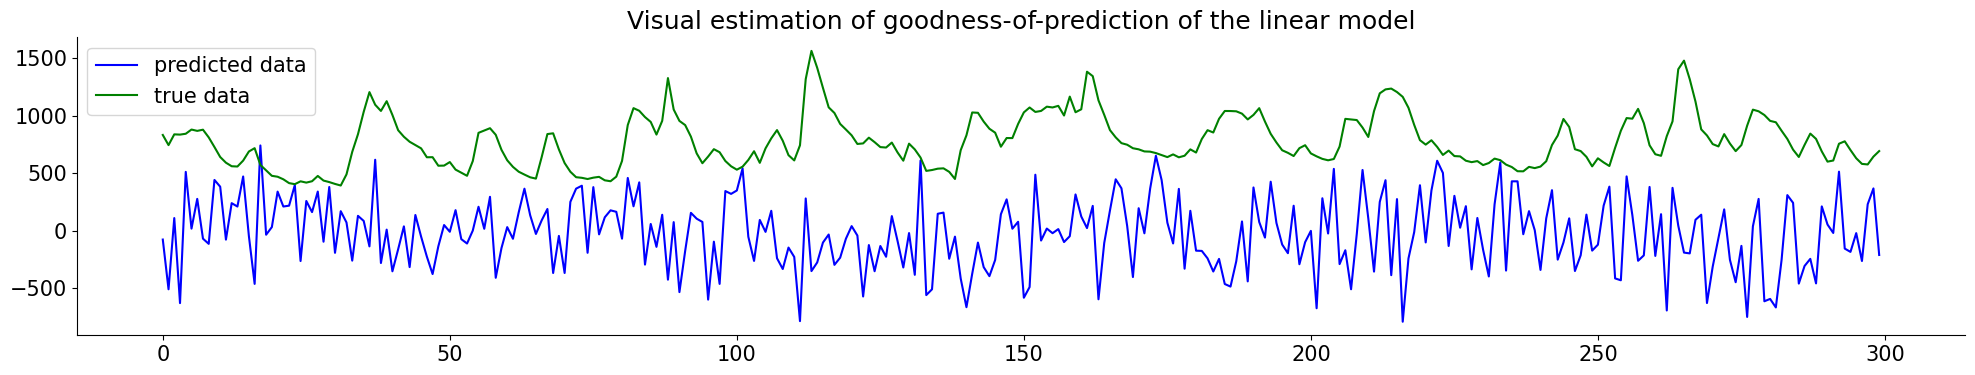

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(predicted_spikes[:300]/500, c='b', label='predicted data')
plt.plot(dat['pupilArea'][:300], c='g', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model')

#Using GLM to predict running speed from neural activity (2)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
pupil = zscore(dat['pupilArea'], axis=0, nan_policy='omit')
eye_pos = dat['pupilCOM']
locomotion = zscore(dat['run'], axis=0, nan_policy='omit')
face_svd = zscore(dat['beh_svd_time'], axis=0, nan_policy='omit')

In [ ]:
def normalize_data(data: np.array, new_min: int, new_max: int, axis=None):
    if axis is None:
        # Perform normalization across the entire array
        return ((data - np.min(data)) * (new_max - new_min) / (np.max(data) - np.min(data))) + new_min
    else:
        # Perform normalization along the specified axis
        min_vals = np.min(data, axis=axis, keepdims=True)
        max_vals = np.max(data, axis=axis, keepdims=True)
        return ((data - min_vals) * (new_max - new_min) / (max_vals - min_vals)) + new_min

# Build the full design matrix
# Predict pupil diameter: y = face movie
y = face_svd
y = normalize_data(y, new_min=0, new_max=1)

# solve: yhat = x theta, theta =X.T y / X.T X
x = neuron_response = dat['sresp']

# Normalize, center to the mean and scale from 0 to 1
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

constant = np.ones((1, x.shape[1])) # accounts for offset
X = np.concatenate([constant, x], axis=0).T

In [ ]:
print(X.shape)
print(y.shape)

(7018, 11984)
(7018, 1000)


In [ ]:
# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y

# Compute predicted spike counts
yhat_np = X @ theta

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(yhat_np[:1500], c='blue', label='predicted data')
plt.plot(y[:1500], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model')

## GLM using the sklearn toolbox

In [ ]:
from sklearn.linear_model import LinearRegression

# assuming y is a 2D array with shape (n_samples, 1)
# and x is a 2D array with shape (n_samples, n_features)
y = np.squeeze(pupil)
y = zscore(y)
y = normalize_data(y, new_min=0, new_max=1)


x = dat['sresp'].T
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

# Initialize the model
model = LinearRegression() # https://scikit-learn.org/stable/modules/linear_model.html

# Fit the model
model.fit(x, y)

# Now, you can predict new data using:
yhat = model.predict(x)

In [ ]:
print(x.shape)
print(y.shape)
print(model.coef_.shape)

(7018, 11983)
(7018,)
(11983,)


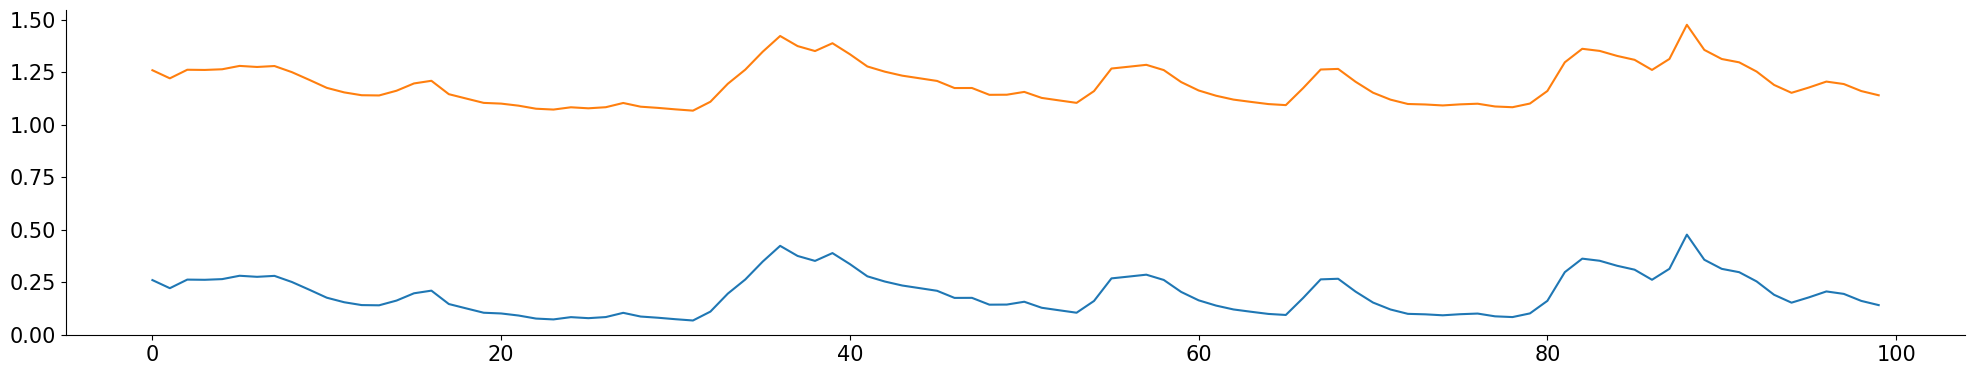

In [ ]:
plt.figure()
plt.plot(yhat[:100])
plt.plot(y[:100] +1)

#L1 regularization

Text(0.5, 1.0, 'Model prediction of held-out test data')

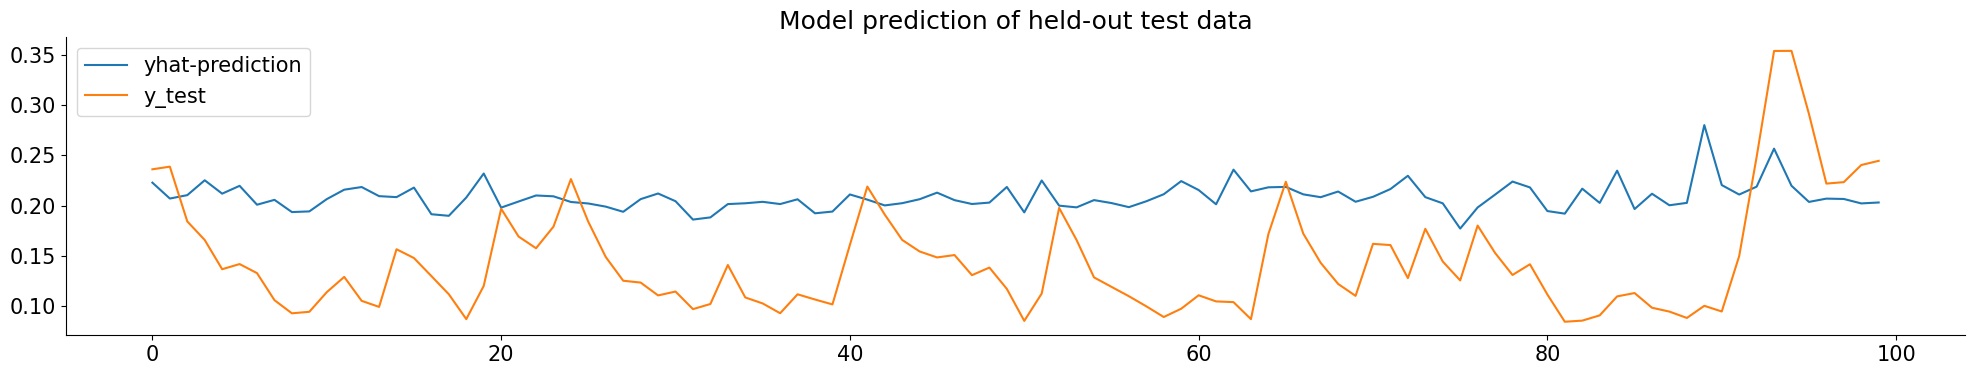

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=False)

reg_l1 = Lasso(alpha= 0.005651659309289696)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)

# Smoothing the predictions using moving average- Chat GPT suggestion
window_size = 5  # Adjust the window size as needed
y_pred_l1_smoothed = np.convolve(y_pred_l1, np.ones(window_size)/window_size, mode='valid')

plt.figure()
plt.plot(y_pred_l1[:100], label='yhat-prediction')
plt.plot(y_test[:100] , label='y_test')
plt.legend()
plt.title('Model prediction of held-out test data')

In [ ]:
# Re-try the OLS Regression, but use the train-test split from Stringer2019
timepoints, no_neurons = x.shape
X_1_train = x[:timepoints//2, :no_neurons//2]
X_1_test = x[timepoints//2:, :no_neurons//2]
X_2_train = x[:timepoints//2, no_neurons//2:]
X_2_test = x[timepoints//2:, no_neurons//2:]
y_train = y[:timepoints//2]
y_test = y[timepoints//2:]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_1_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_1_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Coefficients: 
 [ 0.00156144 -0.04015527 -0.03018462 ... -0.01908584  0.07472023
 -0.00536137]
Mean squared error: 0.02
Coefficient of determination: 0.32


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(regr, x, y, cv=8)  # k=8 cross validation
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies.mean(), accuracies.std()))

0.45 accuracy with a standard deviation of 0.20


Text(0.5, 1.0, 'Model prediction of held-out test data')

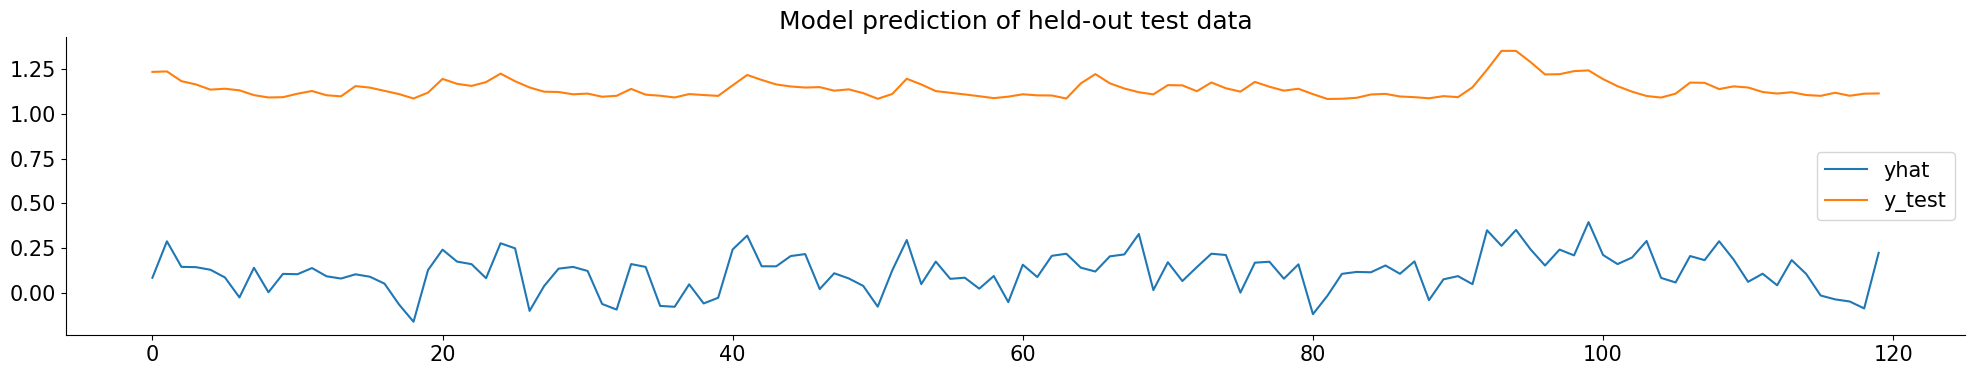

In [ ]:
plt.figure()
plt.plot(y_pred[:120], label='yhat')
plt.plot(y_test[:120] +1, label='y_test')
plt.legend()
plt.title('Model prediction of held-out test data')

#Cross validation

In [ ]:
print(y_pred.shape)
print(y.shape)

(3509,)
(7018,)


In [ ]:
from time import time
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# This is Chat GPT's suggestion on how to implement a good cross-validation scheme for time series data
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

t0 = time()
#lasso_cv takes a cross-validation scheme as a parameter
lasso_cv = LassoCV(cv=tscv).fit(X_train, y_train)
print(f"LassoCV fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso_cv.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"LassoCV r^2 on test data : {r2_score_lasso:.3f}")
print(f"Optimal alpha : {lasso_cv.alpha_}")


LassoCV fit done in 211.239s
LassoCV r^2 on test data : 0.573
Optimal alpha : 2.69960735481984e-05


Text(0.5, 1.0, 'Model prediction of held-out test data')

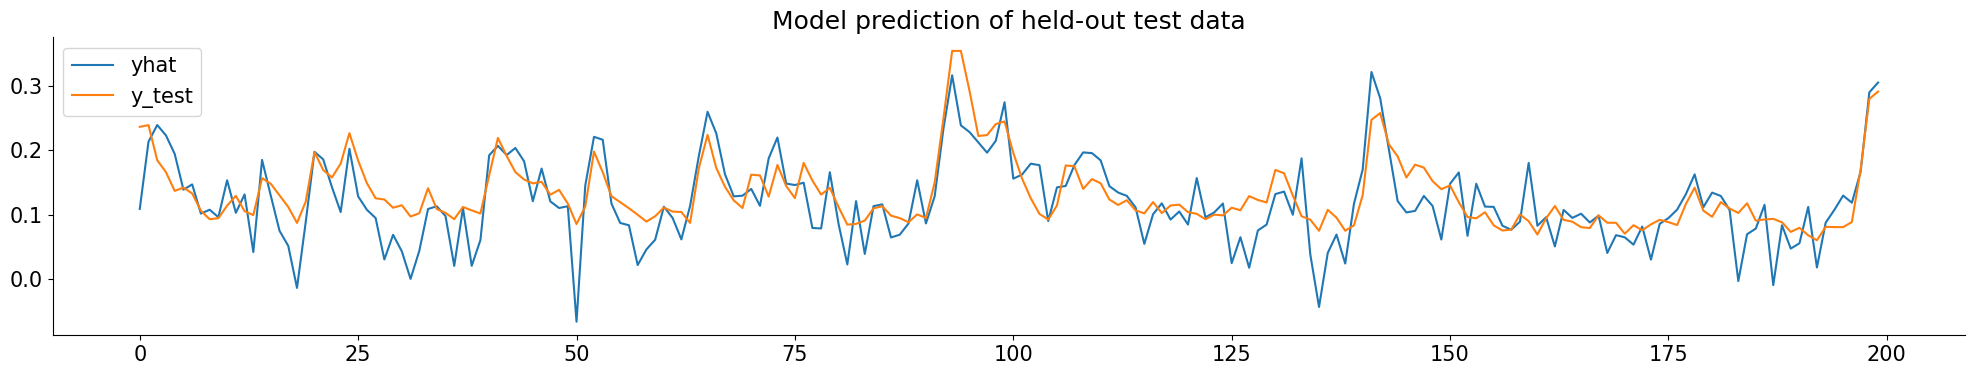

In [ ]:
reg_l1 = Lasso(alpha=lasso_cv.alpha_)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)


plt.figure()
plt.plot(y_pred_l1[:200], label='yhat')
plt.plot(y_test[:200], label='y_test')
plt.legend()
plt.title('Model prediction of held-out test data')

# New section